# Multiparametric MRI - supervised (KNN) tissue classification

v.20200426 (A. Lundervold)

## Learning objectives and context

- In this session you will learn to predict predefined tissue types in a given multispectral MR image using  machine learning (**supervised classification**)


- The supervised classification model we wil use is simple **K-nearest neighbor** classification model, denoted $f$ (described below)


- To perform such pixel-wise tissue classification we will make use of the training (i.e. the `training mask`) we obtained during the **labelling of data** (see figure below of color-coded tissue samples)


- In the previous data labeling step (not part of these notebooks) we defined six different classes (tissue types), denoted $\mathbf y$ and the corresponding four channel multispectral MRI data, dentoted $\mathbf X$. 


- The notebook is thus a practical machine learning example of the formalism: $ y \approx f(\mathbf X, \theta)$


- You will also learn to navigate and appreciate the distinction between **image space** (pixel locations, spatial neiborhoods) and **feature vector space** (signal intensity value combinations, and similarity of pixel-based and tissue-based "signatures").

# Theory:  K-nearest neighbor classication (KNN)

Short description and explanation of [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)-classification:

In pattern recognition, the $K$-nearest neighbors algorithm (K-NN) is a non-parametric method used for **classification** and **regression**. In both cases, the input consists of the $K$ closest training samples in the feature space. The output depends on whether K-NN is used for classification or regression:

 - In **K-NN classification**, the output is a **class membership**. An object is classified by a [plurality vote](https://en.wikipedia.org/wiki/Plurality_voting) of its neighbors, with the object being assigned to the class most common among its $K$ nearest neighbors ($K$ is a positive integer, typically small and odd, 
 e.g. $K \in \{1,3,5,7,9,11\}$, say). 
 
 
 - If $K = 1$, then the object is simply assigned to the class of that single nearest neighbor, i.e. **nearest neighbor classification**.
 
 
 - In **K-NN regression**, the output is the property value for the object. This value is the _average of the values of $K$ nearest neighbors_.

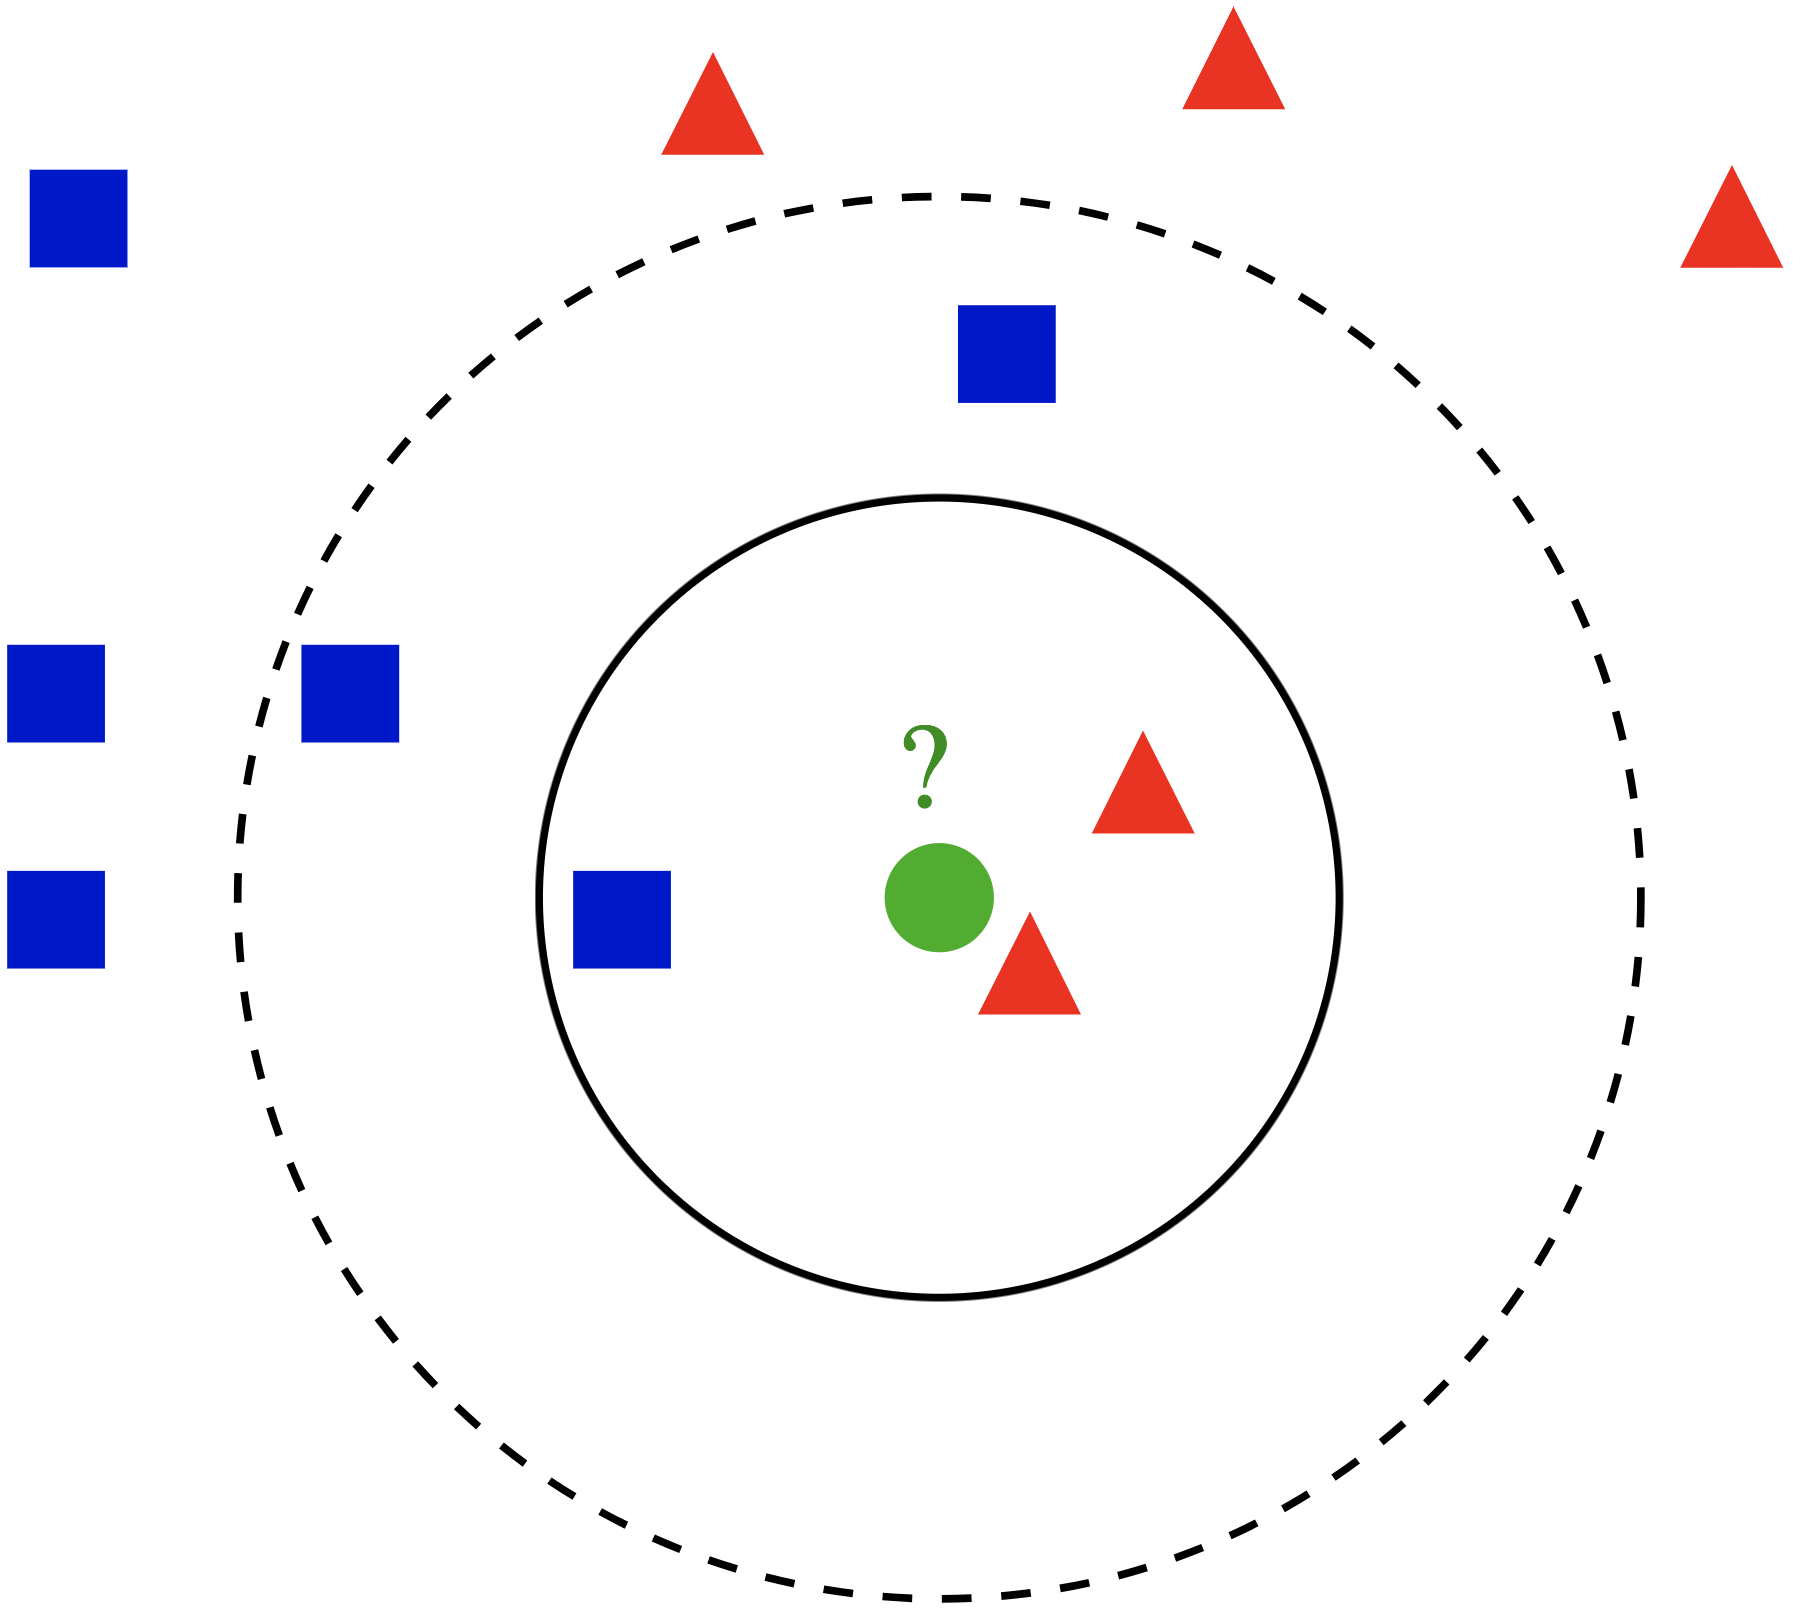

In [1]:
from IPython.display import Image
Image(filename='./assets/knn_illustration.png', width=500)

**_Instance of a K-NN classification_** 

- The test sample (the filled green circle), with unkown class belonging, shall be classified to either the class marked as blue squares or the class marked as red triangles, i.e. a **two-class problem** using K-NN.


- If $K = 3$ (circle drawn with black continuous line) the unkown observation will be assigned the **red triangle class** since there are two red-label samples and only one blue-label sample in the set consisting of the three closest neighbors being labeled (using the Eucledean distance metric).


- If, on the other hand, $K = 5$ (circle drawn with black dashed line) the previously unseen (i.e. not labeled) sample will be assigned the **blue square class** (three blue squares vs. two red triangles among the five closest samples being labeled), i.e. "majority voting". 


- K-NN is a _lazy learner_ because it doesn't learn a discriminative function from the training data but _"memorizes"_ the training dataset instead. For example, the logistic regression algorithm learns its model weights (parameters, $\theta$) during training time.


- For more elaborative explanation, see the Wikipedia entry for the [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

# Four-channel multispectral image and associated training masks

We will be using a four-channel multispectral image (slice 60 from a multispectral 3D recording),  <br>
reported in  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, [[PDF](https://drive.google.com/file/d/17Ut1ScHU4cX5x_EHwQnNwH_q3Lgcq5WA/view)]<br>
and a manually delineated training mask (cf. "labeling of data") consisting of 6 tissue types (color coded in  [R,G,B] space) as follows: 


 - AIR (air/compact bone) in Magenta [255,0,255]
 - GM  (gray matter) in Red  [255,0,0] 
 - WM  (white matter) in Cyan [0,255,255]
 - CSF (cerebrospinal fluid) in Blue [0,0,255]
 - MUS (muscle) in Green [0,255,0] 
 - FAT (fat) in Yellow [255,255,0]
 
and a manually delineated `head ROI mask` for spatial restriction of the supervised pixel classification.


**Chek out:** <br>
*Multispectral MRI analysis started with the seminal work of [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 - inspired by the research (on remote sensing) at NASA!*

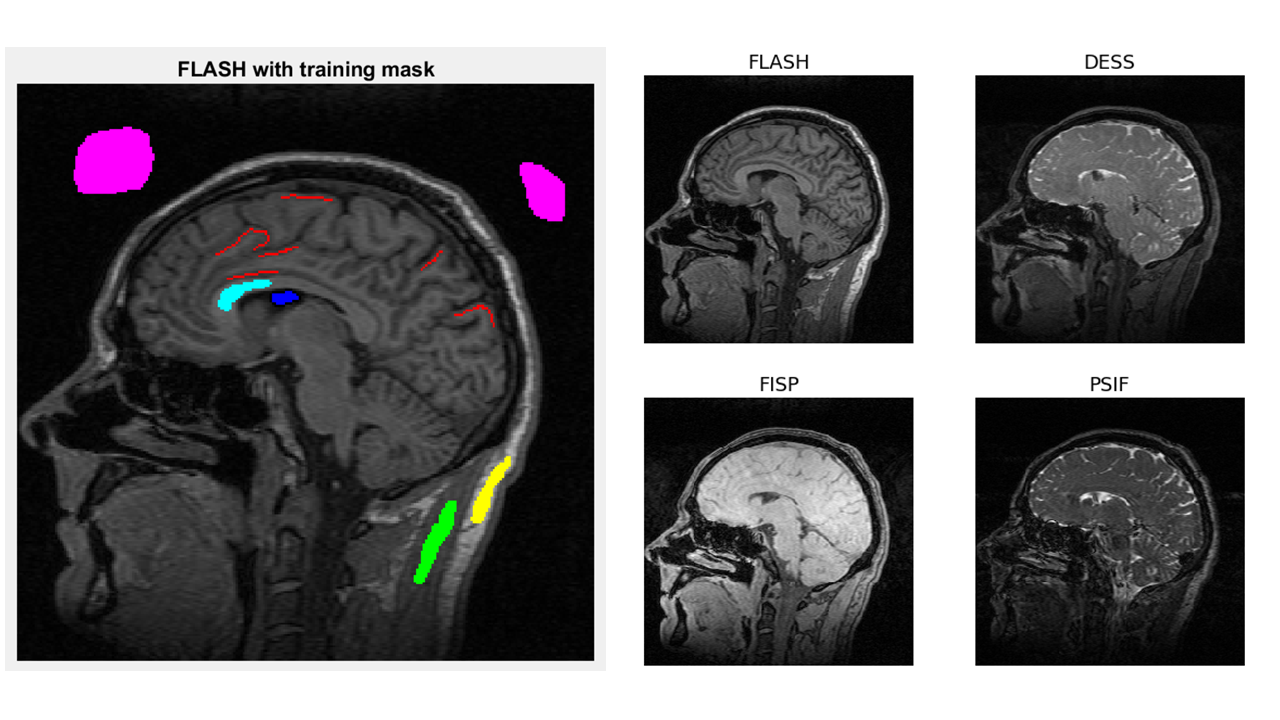

In [2]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

# Set up our Python environment

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython
print('nibabel:', nib.__version__)
import sklearn
print('scikit-learn:', sklearn.__version__)
home = os.path.expanduser('~')  # To make path to local home directory

nibabel: 3.1.0
scikit-learn: 0.22.1


# MRI pulse sequenses (features) and tissue types (classes)

**Define channel names (MRI pulse sequence acronyms) and class labels (tissue types) that are used**

In [4]:
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

# Load a multispectral MR image, training masks and ROI mask

In [5]:
# Using nibabel to read the multispectral image (and the training mask)
fn_multispectral = './data/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)
fn_tmsk = './data/training_mask_1_6.nii.gz'
tmsk = nib.load(fn_tmsk)
fn_roimsk = './data/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)

## Show properties of the multispectral NIFTI image

In [6]:
print('**Multispectral image info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
dat = img.get_fdata()
print('min = %.1f' % dat.min())
print('max = %.1f' % dat.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
data = np.uint16(dat.squeeze())
print('shape of 2D+spectral img_data = ',data.shape)
print('dtype of 2D+spectral img_data = ',data.dtype)
print('img affine:', img.affine)

**Multispectral image info:**
shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral img_data =  (256, 256, 4)
dtype of 2D+spectral img_data =  uint16
img affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


#### and the corresponding training mask 

In [7]:
print('**Training mask info:**')
print('shape = ', tmsk.header.get_data_shape())
print('voxel size = ', tmsk.header.get_zooms())
print('dtype tmsk = %s' % tmsk.header.get_data_dtype())
tmsk_data = tmsk.get_fdata().squeeze()
print('min mask value = %.0f' % tmsk_data .min())
print('max mask value = %.0f' % tmsk_data .max())
print('shape of 2D tmsk_data = ', tmsk_data.shape)
print('tmsk affine:', tmsk.affine)

**Training mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype tmsk = int16
min mask value = 0
max mask value = 6
shape of 2D tmsk_data =  (256, 256)
tmsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


#### and the ROI (head mask)

In [8]:
print('**Brain ROI mask info:**')
print('shape = ', roimsk.header.get_data_shape())
print('voxel size = ', roimsk.header.get_zooms())
print('dtype roimsk = %s' % roimsk.header.get_data_dtype())
roimsk_data = roimsk.get_fdata().squeeze()
print('min mask value = %.0f' % roimsk_data .min())
print('max mask value = %.0f' % roimsk_data .max())
print('shape of 2D roimsk_data = ', roimsk_data.shape)
print('roimsk affine:', roimsk.affine)

**Brain ROI mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype roimsk = int16
min mask value = 0
max mask value = 1
shape of 2D roimsk_data =  (256, 256)
roimsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


# Display the multispectral image as separate channel images 

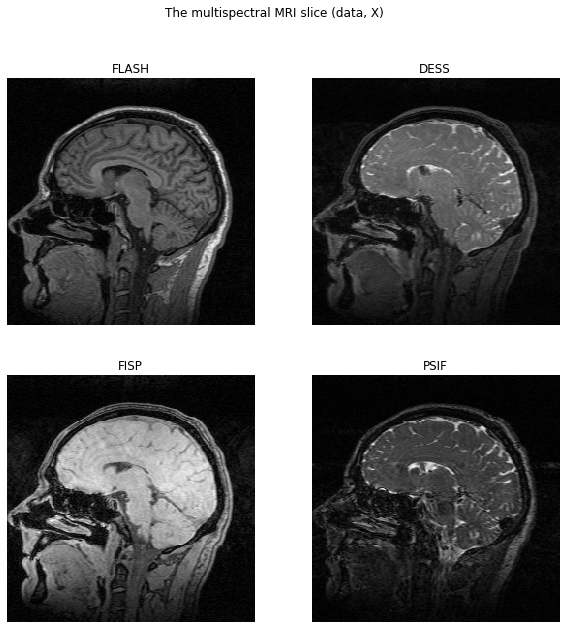

In [9]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle("The multispectral MRI slice (data, X)") 
plt.tight_layout
plt.show()

# Show the training mask with color-coded class (tissue type) labels


(according to a pre-defined color lookup table, or LUT )

We use a **dictionary** for the color LUT:

In [10]:
import matplotlib
col_code = {
    'BCK': [255,255,255], # White (background)
    'AIR': [255,0,255],   # Magenta 
    'GM':  [255,0,0],     # Red 
    'WM':  [0,255,255],   # Cyan 
    'CSF': [0,0,255],     # Blue 
    'MUS': [0,255,0],     # Green 
    'FAT': [255,255,0]    # Yellow 
}
cla_names = list(col_code.keys())
ncla = len(cla_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
cla_cmap = matplotlib.cm.get_cmap(mycmap, ncla)   # ncla discrete colors

Construct a list of class names and corresponding class numbers

In [11]:
cla_names_num = []
for i in range(ncla):
    str = cla_names[i] + ' [%d]' % (i)
    cla_names_num.append(str)
cla_names_num

['BCK [0]', 'AIR [1]', 'GM [2]', 'WM [3]', 'CSF [4]', 'MUS [5]', 'FAT [6]']

### Make a figure showing the color-coded labeled pixels (training mask)

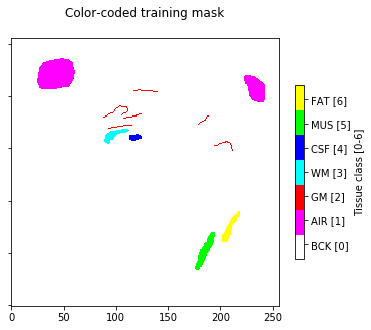

In [12]:
fig, ax = plt.subplots(figsize=(6,8))

cmsk = ax.imshow(tmsk_data[:, :].T)
clim=cmsk.properties()['clim']
cax = ax.imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower', clim=clim)
ax.set_title('Color-coded training mask\n')
ax.axis('on')
ax.set_yticklabels("")
#ax.set_xticklabels("")
cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)
plt.tight_layout
plt.show()

#fig.savefig('%s/prj/BMED360-2020/results/training_mask_1_6_color_coded.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

#  We make a data frame (FVB) from the MRI data and training mask 

FVB = **Feature Vector Base**; the training mask is here a **multiclass training mask**

- Using `np.where()` to find locations to those pixels containing tissue being labelled

- Thereafter extract the corresponding data (feature vectors) from the multispectral image being spatially aligned with the training mask:

In [13]:
# Find pixel locations corresponding to AIR (class 1), GM (class 2), ..., FAT (class 6)
frames = pd.DataFrame()   # Create an empty data frame
for cn, cla in enumerate(class_names):
    ind = np.where(tmsk_data == cn+1)  # Find indices (x,y) for given class, class numbers start at 1 (not 0)
    df = pd.DataFrame(np.asarray(data[ind[0][:],ind[1][:],:]), columns = chn_names)
    df.insert(len(df.columns), 'Class', class_names[cn].upper())  # Last entry is class name
    frames = frames.append(df)
    
# Concatinate the frames
FVB = pd.concat([frames], ignore_index=True)

**Check some training data:** $(x_1^i, x_2^i,x_3^i, x_4^i, y^i)$ <br>
for $i=0,1,\ldots,4$ and for $i=N-4, N-3,\ldots,N$, where $N$ is the total number of pixels being labelled

In [14]:
FVB.head()

,FLASH,DESS,FISP,PSIF,Class
0,7,6,10,2,AIR
1,0,6,8,0,AIR
2,8,2,4,11,AIR
3,3,7,2,11,AIR
4,5,3,0,6,AIR


In [15]:
FVB.tail()

,FLASH,DESS,FISP,PSIF,Class
1981,281,60,167,176,FAT
1982,305,58,167,164,FAT
1983,303,53,172,185,FAT
1984,281,65,145,176,FAT
1985,287,53,148,214,FAT


**Class-specific summary statistics** from the FVB accross the different features (channels, or pulse sequences)

In [16]:
FVB.groupby('Class').describe(percentiles = [0.5]).round(3).T

Class             AIR      CSF      FAT       GM      MUS       WM
FLASH count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.054   29.196  264.435  112.728  101.336  162.721
      std       3.467    6.672   40.778   11.184    8.806    6.870
      min       0.000   13.000  140.000   91.000   79.000  132.000
      50%       6.000   30.000  271.000  112.000  103.000  163.000
      max      19.000   46.000  338.000  152.000  123.000  178.000
DESS  count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.925  129.294   45.176  127.426   50.768  117.876
      std       4.885   70.856    9.184   19.702    7.178    6.721
      min       0.000   42.000   24.000  100.000   28.000  101.000
      50%       6.000  110.000   45.000  124.500   51.000  118.000
      max      26.000  258.000   71.000  217.000   70.000  137.000
FISP  count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.551   71.039  133.688  171.596  103.372  187.752
      std       4.468   12.167   25.817   16.722   21.548    8.113
      min       0.000   50.000   72.000  127.000   34.000  174.000
      50%       5.000   70.000  135.000  172.000  102.000  187.000
      max      26.000   99.000  185.000  221.000  144.000  209.000
PSIF  count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.005  285.412  152.312  154.750   45.328  112.364
      std       3.445  104.923   28.726   68.427   12.104   18.024
      min       0.000  104.000   68.000  103.000   19.000   66.000
      50%       6.000  324.000  154.000  126.000   45.000  113.000
      max      19.000  418.000  214.000  439.000   78.000  168.000

# Save dataframe FVB from the labeled NIFTI data as a .csv file

In [17]:
FVB.to_csv('./data/multispectral_mri_training_data_from_nifti_mask.csv', index=False)

# Supervised classification with the KNN algorithm 

**See also https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch**


# Read the  training data (`X` and `y`)

In [18]:
FVB = pd.read_csv('./data/multispectral_mri_training_data_from_nifti_mask.csv')
FVB.head()

,FLASH,DESS,FISP,PSIF,Class
0,7,6,10,2,AIR
1,0,6,8,0,AIR
2,8,2,4,11,AIR
3,3,7,2,11,AIR
4,5,3,0,6,AIR


## Separate the data matrix `X_train` from the corresponding vector of labels `y_train`  in the FVB dataframe

In [19]:
#x_train = FVB.drop('Class', axis=1)
#y_train = FVB['Class']

In [20]:
X_train = FVB.iloc[:, :-1].values.astype(float)
y_train = FVB.iloc[:, -1].values                 # Last column is 'Class'

In [21]:
X_train.shape

(1986, 4)

# Load the  test data set `X_test` defined by the head `ROI mask`

For being able to map classified pixels (i.e. pixel-based feature vectors in **signal intensity space** $\subset \mathbf R^4$) back into **image space** $\subset \mathbf N^+ \times \mathbf N^+$ we will need to store their row-column $(i, j)$ locations - not only the feature vectors.

In [22]:
fn_roimsk = './data/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)
roimsk_data = roimsk.get_fdata().squeeze()

# For using the whole image as ROI, uncomment
# roimsk_data = np.ones(roimsk_data.shape)

## Find all pixel locations in the ROI to extract the test data matrix, `X_test`

**and save the test data samples and their corresponding pixel locations as a Pandas dataframe**

In [23]:
# Find pixel locations corresponding to brain ROI (value 1) 
ind_test = np.where(roimsk_data == 1) 
X_test = np.asarray(data[ind_test[0][:],ind_test[1][:],:]) # The multispectral signal intensities
dfTest = pd.DataFrame(X_test, columns = chn_names)
dfTest.insert(loc = len(dfTest.columns),
           column = 'row',
           value = ind_test[0])  # Row of pixel location
dfTest.insert(loc = len(dfTest.columns),
           column = 'col',
           value = ind_test[1])  # Col of pixel location

In [24]:
dfTest.head()

,FLASH,DESS,FISP,PSIF,row,col
0,149,66,67,66,20,121
1,129,90,86,106,20,122
2,101,83,146,81,20,123
3,28,79,158,40,20,124
4,7,53,155,67,20,125


In [25]:
dfTest.tail()

,FLASH,DESS,FISP,PSIF,row,col
35817,10,13,29,6,239,150
35818,8,18,29,6,239,151
35819,12,18,20,8,239,152
35820,0,20,25,16,239,153
35821,9,26,19,19,239,154


## Scaling of feature vectors  (MRI signal intensities) in `X_train` and `X_test` 

### $\rightarrow$ Your turn

#### Why should we consider feature scaling (normalization) in machine learning?

(Hint: See https://en.wikipedia.org/wiki/Feature_scaling)

We will use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from `scikit-learn`

In [26]:
scaler = StandardScaler()  
scaler.fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train.astype(float))  
X_test_scaled = scaler.transform(X_test.astype(float)) 

We make Pandas dataframes from the pair of scaled X_train (`dX`) and corresponding y_train (`dy`) to confirm the effect of feature scaling, i.e.

In [27]:
dX = pd.DataFrame(X_train_scaled, columns=chn_names)
dy = pd.DataFrame(y_train, columns=['Class'])
FVB_train = pd.concat([dX, dy], axis=1)
FVB_train.describe(percentiles = [0.5]).round(4).T

,count,mean,std,min,50%,max
FLASH,1986.0,0.0,1.0003,-0.7119,-0.6019,3.4196
DESS,1986.0,-0.0,1.0003,-0.7713,-0.5691,5.0273
FISP,1986.0,0.0,1.0003,-0.8068,-0.6583,2.4738
PSIF,1986.0,0.0,1.0003,-0.6589,-0.5347,5.3990


**this demonstrates that we have obtained `zero mean` and `unit variance` for each feature in the training data after scaling** 

# Estimate (fit) a KNN classifier given the training data set 

**for (non-scaled) training data**

We use [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) from `scikit-learn`

# We try K=1

In [28]:
K = 1
classifier = KNeighborsClassifier(n_neighbors=K)  
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Prediction (y_train_pred) on the training dataset, (X_train)

- In our case, we have not labeled all the pixels in the ROI (that will take a lot of time and effort, and also be prone to intra and inter observer variation). 


- Thus, we do not have the "ground truth" i.e. y_test (only y_train)


- We have to rely on **plausible results** (not quantitative performance metrices), regarding the test dataset (see later).


- Initially, we examine the performance of our classifier on the training dataset.


- Usually, the classifier should perform very well on training data (by the very construction of the classifier), and we will examine this situation.


- We obtain perfect classification! (as seen below)

In [29]:
y_train_pred = classifier.predict(X_train) 

##  Performance evaluation on the traing dataset using the `confusion matrix` 

In [30]:
print(confusion_matrix(y_train, y_train_pred))  

[[1250    0    0    0    0    0]
 [   0   51    0    0    0    0]
 [   0    0  170    0    0    0]
 [   0    0    0  136    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    0    0  129]]


### $\rightarrow$ Your turn!

> #### Why are we guaranteed the confusion matrix being **diagonal** in this case?
> #### What assumption do we make to give such a guarantee?

## Evaluation on the training dataset according to a `classification_report` 

Check the documentation in  [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) from the `scikit-learn` library

In [31]:
print(classification_report(y_train, y_train_pred)) 

              precision    recall  f1-score   support

         AIR       1.00      1.00      1.00      1250
         CSF       1.00      1.00      1.00        51
         FAT       1.00      1.00      1.00       170
          GM       1.00      1.00      1.00       136
         MUS       1.00      1.00      1.00       250
          WM       1.00      1.00      1.00       129

    accuracy                           1.00      1986
   macro avg       1.00      1.00      1.00      1986
weighted avg       1.00      1.00      1.00      1986



# No, we try  K >> 1

In [32]:
K = 51
classifier = KNeighborsClassifier(n_neighbors=K)  
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train) 

## Performance evaluation

In [33]:
print(confusion_matrix(y_train, y_train_pred))  

[[1250    0    0    0    0    0]
 [   0   38    0    0   13    0]
 [   0    0  170    0    0    0]
 [   0    4    0  132    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    1    0  128]]


In [34]:
 print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         AIR       1.00      1.00      1.00      1250
         CSF       0.90      0.75      0.82        51
         FAT       1.00      1.00      1.00       170
          GM       0.99      0.97      0.98       136
         MUS       0.95      1.00      0.97       250
          WM       1.00      0.99      1.00       129

    accuracy                           0.99      1986
   macro avg       0.97      0.95      0.96      1986
weighted avg       0.99      0.99      0.99      1986



### $\rightarrow$ Your turn!

> #### Do experimentes on the training dataset with K-NN for different values of K, e.g. $K \in \{3, 5, 27, 51\}$ and check the corresponding confusion matrix.
> #### Why do we frequently get non-diagonal confusion matrices in this case?

# Prediction on the scaled `X_test` dataset 
### (delineated by the head ROI mask)

**Initially we let K=5 and use feature scaling  "zero mean unit variance" across all classes** 

In [35]:
K = 5
classifier = KNeighborsClassifier(n_neighbors=K)
classifier.fit(X_train_scaled, y_train)
# classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

**Prediction on the scaled `X_test_scaled` dataset (delineated by the head ROI mask)**

In [36]:
y_pred = classifier.predict(X_test_scaled)
# y_pred = classifier.predict(X_test)

## Prediction results

In [37]:
print('Number of classified pixels:', len(y_pred))
print('\nThe first 10 predictions in ROI:', y_pred[:10])

Number of classified pixels: 35822

The first 10 predictions in ROI: ['MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'CSF' 'CSF' 'AIR' 'AIR']


- **Make a Pandes dataframe for the prediction** 

- **Later we will transform named tissue types to a numerical encoding using a dictionary**

In [38]:
df_y_pred = pd.DataFrame(y_pred,  columns=['Class'])
print(df_y_pred.info())
df_y_pred.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35822 entries, 0 to 35821
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   35822 non-null  object
dtypes: object(1)
memory usage: 280.0+ KB
None


,0,1,2,3,4
Class,MUS,MUS,MUS,MUS,MUS


In [39]:
df_y_pred.tail().T

,35817,35818,35819,35820,35821
Class,AIR,AIR,AIR,AIR,AIR


Construct a **dictionary** that defines a ono-to-one map between tissuse type *names* and tissue type classes as *numbers*

In [40]:
cla_code = {
    'BCK': 0, # White (background)  Color-coding according to cla_cmap defined above
    'AIR': 1, # Magenta 
    'GM':  2, # Red 
    'WM':  3, # Cyan 
    'CSF': 4, # Blue 
    'MUS': 5, # Green 
    'FAT': 6  # Yellow 
}

df_y_pred['Class'] = df_y_pred['Class'].map(cla_code) 
# Note: if the dictionary does not exhaustively map all entries
#       then non-matched entries are changed to NaNs

## We select the FLASH channel (high CNRs) for the superposition of the KNN tissue type classification 

**Initially, we "lift" (i.e. add a constant to) the range of signal intensities in the FLASH channels to avoid mixing data values in FLASH with the overlay of tissue class numbers**

In [41]:
# Adding max classnumber + 1 to the FLASH data to avoid mixing data values with predicted class-numbers
cla_data = np.int16((data[:,:,0].copy().squeeze() + (df_y_pred.values.max() + 1)*np.ones(tmsk_data.shape)))
mx = cla_data.max()
mn = cla_data.min()
print('min - max =', mn, '-', mx)

# Scaling to range [0, 1]
cla_data = cla_data/mx
mx = cla_data.max().round(4)
mn = cla_data.min().round(4)
print('min - max =', mn, '-', mx)
cla_data.shape

min - max = 7 - 364
min - max = 0.0192 - 1.0


(256, 256)

**Fill the `cla_data` matrix with the pixel-wise KNN predictions (scaled to the interval [0, 1])**

In [42]:
mx = df_y_pred['Class'].values.max()  # Max class value

**Insert the predicted class numbers in the corresponding pixel locations (row, col) in the head ROI mask, i.e. going from feature space to image space**

In [43]:
cla_data[dfTest['row'].values, dfTest['col'].values] = df_y_pred['Class'].values / mx

## Inspect the tissue classification using both color-coding and gray-level coding 

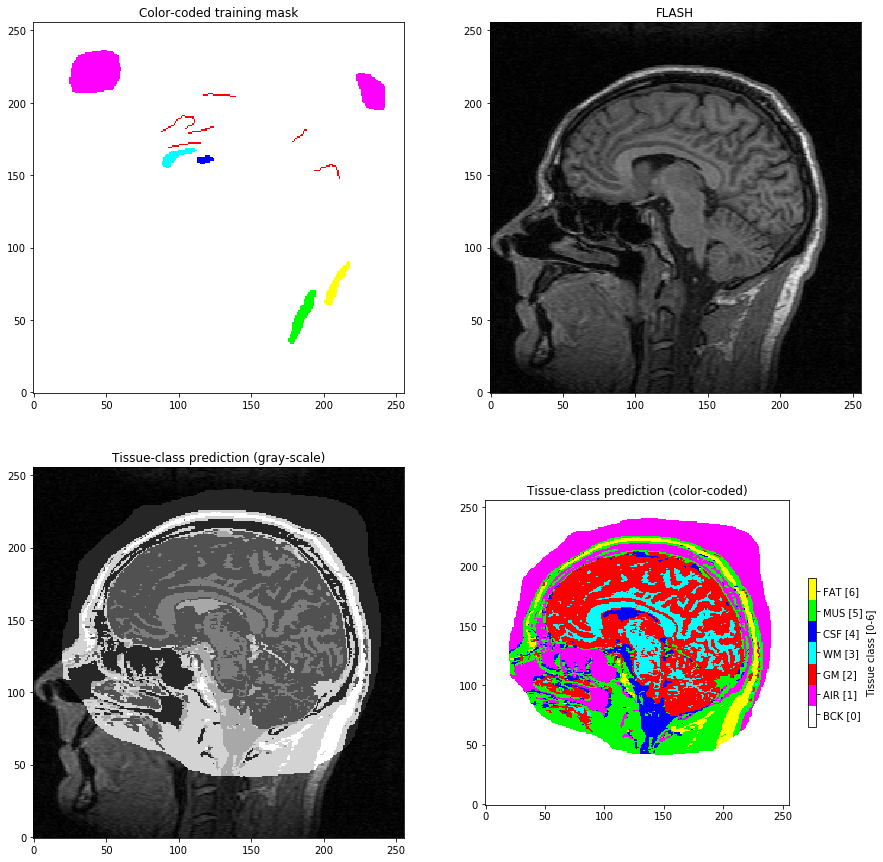

In [44]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
ax = axes.ravel()

ax[0].imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower')
ax[0].set_title('Color-coded training mask')
ax[0].axis('on')

ax[1].imshow(data[:, :, 0].squeeze().T, cmap='gray', origin='lower')
ax[1].set_title('FLASH')

# Hadamar (elemnt-wise) product np.multiply(a,b)
ax[2].imshow(cla_data[:, :].T / mx, cmap='gray', origin='lower')
ax[2].set_title('Tissue-class prediction (gray-scale)')

ax[3].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[3].set_title('Tissue-class prediction (color-coded)')

cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)

plt.show()

# Uncomment and adjust your local project directory for saving your results or figures
#fig.savefig('%s/prj/BMED360-2020/results/KNN_classification_results_on_flash.png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

### $\rightarrow$ Your turn!

> #### Discuss the K-NN classification results (e.g. plausibility? any likely misclassifications? ....)
> #### Repeat the KNN-classification experiments using the original signal intensities  (no feature scaling)
> #### Compare and discuss your findings with those obtained using feature scaling
> #### How could you quantitatively assess the difference in predictions between *feauture scaling* and *no feature scaling*?

# EXTRA:  Tissue classification using the Random Forest classifier

  **where tha class labels are mapped to numeric values**

In [45]:
df_y_train = pd.DataFrame(y_train,  columns=['Class'])
print(df_y_train.info())
df_y_train.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   1986 non-null   object
dtypes: object(1)
memory usage: 15.6+ KB
None


,0,1,2,3,4
Class,AIR,AIR,AIR,AIR,AIR


In [46]:
df_y_train['Class'] = df_y_train['Class'].map(cla_code)
y_train_num = df_y_train['Class'].values

**Random Forest** classifier:

In [47]:
classifierRF = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [48]:
classifierRF.fit(X_train_scaled, y_train_num)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
y_rf_pred = classifierRF.predict(X_test_scaled)

Fill a data matrix `cla_data_rf` with the pixel-wise RF predicitons (scaled to the interval [0, 1])

In [50]:
mx = df_y_pred['Class'].values.max()  # Max class value
cla_data_rf = cla_data.copy()
cla_data_rf[dfTest['row'].values, dfTest['col'].values] = y_rf_pred / mx

# Visual comparison between the KNN and the RF predictions

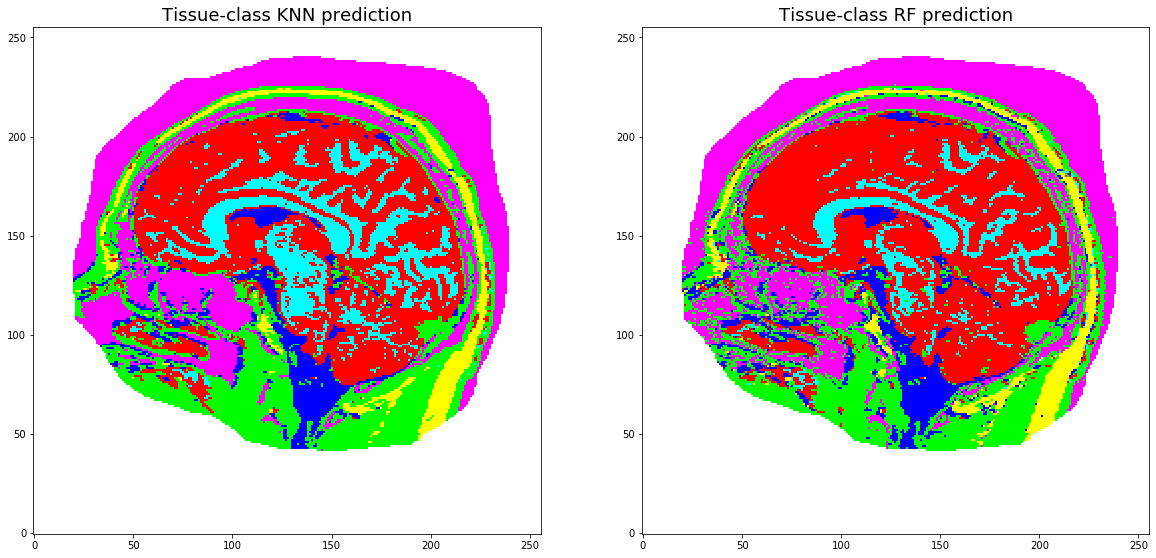

In [51]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[0].set_title('Tissue-class KNN prediction', fontsize=18)
ax[1].imshow(np.multiply(cla_data_rf[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[1].set_title('Tissue-class RF prediction', fontsize=18)
plt.show()


### $\rightarrow$ Your turn!

> #### Which classifier KNN or RF seems to do the best job (giving the most plausible results)? 
> #### The RF classifier has several hyperparameters. Could you tune these to improve performance (visually assessed)

## Evaluation of results - Confusion matrix between KNN and RF classification
**i.e. y_pred_knn ("true") versus y_pred_rf**

In [52]:
from utils import plot_confusion_matrix, plot_confusion_matrix_with_colorbar

In [53]:
y_pred_knn = df_y_pred['Class'].values

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_knn, y_rf_pred)
print(cm)

[[ 8250     0     0    17   882     0]
 [   11 10283   125   161   189     7]
 [    0  1616  2372     0    67     3]
 [   68   115     0  2119   103     1]
 [  500   279    68   539  6045   281]
 [   13     5    31    48     4  1620]]


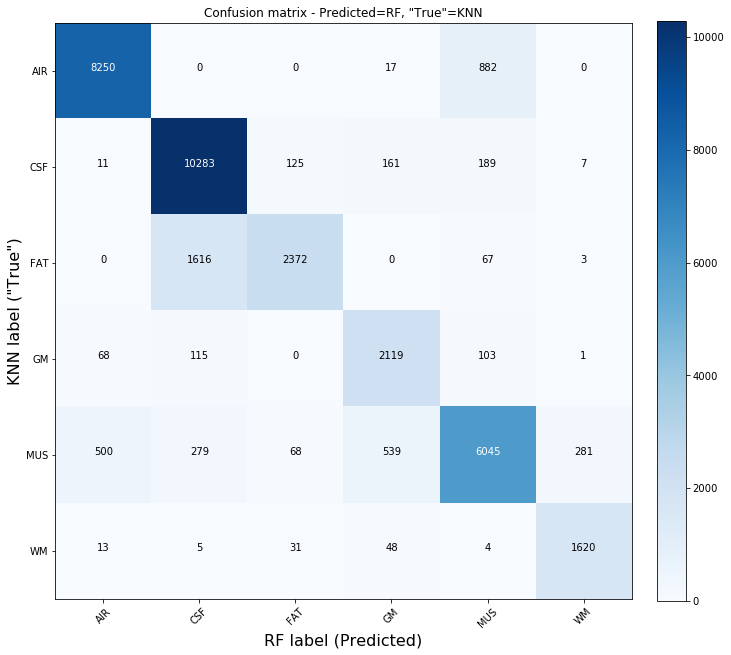

In [55]:
plot_confusion_matrix_with_colorbar(cm, classes=np.unique(y_pred), title='Confusion matrix - Predicted=RF, "True"=KNN', figsize=(10,10))
plt.ylabel('KNN label ("True")')
plt.xlabel('RF label (Predicted)')
plt.show()

Or, using Seaborn's `heatmap`:

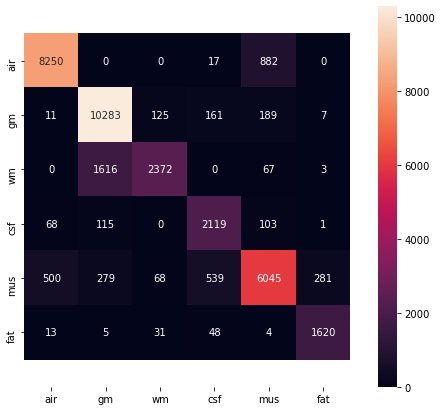

In [56]:
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,7))
ax=sn.heatmap(df_cm, annot=True, fmt='d', square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### $\rightarrow$ Your turn!

> #### Could you suggest (or try out) any other classification methods for this task and the given data?
HINT: Check https://scikit-learn.org/stable/supervised_learning.html#supervised-learning